# DDPG implementation on Bipedalwalker

## 1. Import libraries

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam


## 2. Classes for Critic and Actor networks

In [2]:
class CriticNetwork(keras.Model):
    def __init__(self, actionsNumber, fc1Dim, fc2Dim):
        # Initialise
        super(CriticNetwork, self).__init__()
        self.fc1Dim = fc1Dim
        self.fc2Dim = fc2Dim
        self.actionsNumber = actionsNumber
        
        # FC layers
        self.fc1 = Dense(self.fc1Dim, activation='relu')
        self.fc2 = Dense(self.fc2Dim, activation='relu')
        self.q = Dense(1, activation=None)

    def call(self, inputs):
        state, action = inputs
        action_value = self.fc1(tf.concat([state, action], axis=1))
        action_value = self.fc2(action_value)

        q = self.q(action_value)

        return q


class ActorNetwork(keras.Model):
    def __init__(self, actionsNumber, fc1Dim, fc2Dim):
        # Initialise
        super(ActorNetwork, self).__init__()
        self.fc1Dim = fc1Dim
        self.fc2Dim = fc2Dim
        self.actionsNumber = actionsNumber

        # FC layers
        self.fc1 = Dense(self.fc1Dim, activation='relu')
        self.fc2 = Dense(self.fc2Dim, activation='relu')
        self.mu = Dense(self.actionsNumber, activation='tanh')

    def call(self, state):
        prob = self.fc1(state)
        prob = self.fc2(prob)

        mu = self.mu(prob)

        return mu

## 3. Buffer Class

In [3]:
class ReplayBuffer():
    def __init__(self, maxSize, inputShape, actionsNumber):
        self.memorySize = maxSize
        self.memoryCounter = 0
        # Initialise replay buffer (s, a, r, s')
        self.stateBuffer = np.zeros((self.memorySize, *inputShape))
        self.actionBuffer = np.zeros((self.memorySize, actionsNumber))
        self.rewardBuffer = np.zeros(self.memorySize)
        self.newStateBuffer = np.zeros((self.memorySize, *inputShape))
        self.terminalBuffer = np.zeros(self.memorySize, dtype=np.bool_)

    def transition(self, state, action, reward, nextState, done):
        index = self.memoryCounter % self.memorySize
        self.stateBuffer[index] = state
        self.actionBuffer[index] = action
        self.rewardBuffer[index] = reward
        self.newStateBuffer[index] = nextState
        self.terminalBuffer[index] = done

        self.memoryCounter += 1
        return None

    def sample(self, batchSize):
        maxMemory = min(self.memoryCounter, self.memorySize)
        batchNumber = np.random.choice(maxMemory, batchSize)

        states = self.stateBuffer[batchNumber]
        actions = self.actionBuffer[batchNumber]
        rewards = self.rewardBuffer[batchNumber]
        nextStates = self.newStateBuffer[batchNumber]
        dones = self.terminalBuffer[batchNumber]

        return states, actions, rewards, nextStates, dones

## 4. Agent Class

In [4]:
class Agent:

    def __init__(self, inputShape=None, alpha=0.0001, beta=0.001, env=None, gamma=0.99, actionsNumber=2, maxSize=1000000, tau=0.001, fc1=256, fc2=256, batchSize=64, noise=0.1, checkpoint='model_checkpoint/ddpg/'):
        self.gamma = gamma
        self.tau = tau
        self.memory = ReplayBuffer(maxSize, inputShape, actionsNumber)
        self.batchSize = batchSize
        self.actionsNumber = actionsNumber
        self.noise = noise
        self.maxAction = env.action_space.high[0]
        self.minAction = env.action_space.low[0]
        self.checkpoint = checkpoint

        # Initialise networks
        self.actor = ActorNetwork(actionsNumber=actionsNumber,fc1Dim=fc1, fc2Dim=fc2)
        self.critic = CriticNetwork(actionsNumber=actionsNumber, fc1Dim=fc1, fc2Dim=fc2)
        self.targetActor = ActorNetwork(actionsNumber=actionsNumber, fc1Dim=fc1, fc2Dim=fc2)
        self.targetCritic = CriticNetwork(actionsNumber=actionsNumber, fc1Dim=fc1, fc2Dim=fc2)

        # Compile networks
        self.actor.compile(optimizer=Adam(learning_rate=alpha))
        self.critic.compile(optimizer=Adam(learning_rate=beta))
        self.targetActor.compile(optimizer=Adam(learning_rate=alpha))
        self.targetCritic.compile(optimizer=Adam(learning_rate=beta))

        self.updateParameters(tau=1)

    def updateParameters(self, tau=None):
        if tau is None:
            tau = self.tau

        weights = []
        targets = self.targetActor.weights

        # Soft Copy 
        for i, weight in enumerate(self.actor.weights):
            weights.append(weight * tau + targets[i]*(1-tau))
        self.targetActor.set_weights(weights)

        weights = []
        targets = self.targetCritic.weights
        for i, weight in enumerate(self.critic.weights):
            weights.append(weight * tau + targets[i]*(1-tau))
        self.targetCritic.set_weights(weights)

    def transition(self, state, action, reward, nextState, done):
        self.memory.transition(state, action, reward, nextState, done)

    def save(self):
        print('')
        print('save models')
        self.actor.save(self.checkpoint+'actor')
        self.targetActor.save(self.checkpoint+'targetActor')
        self.critic.save(self.checkpoint+'critic')
        self.targetCritic.save(self.checkpoint+'targetCritic')

    def load(self):
        print('')
        print('load models')
        self.actor = keras.models.load_model(self.checkpoint+'actor')
        self.targetActor = keras.models.load_model(self.checkpoint+'targetActor')
        self.critic = keras.models.load_model(self.checkpoint+'critic')
        self.targetCritic = keras.models.load_model(self.checkpoint+'targetCritic')

    def chooseAction(self, observation, evaluate=False):
        state = tf.convert_to_tensor([observation], dtype=tf.float32)
        actions = self.actor(state)
        if not evaluate:
            # adding gussian noise to every action selection
            actions += tf.random.normal(shape=[self.actionsNumber], mean=0.0, stddev=self.noise)
        # max action when action is more than one
        actions = tf.clip_by_value(actions, self.minAction, self.maxAction)
        return actions[0]

    def learn(self):
        if self.memory.memoryCounter < self.batchSize:
            return None

        # Sampling state action reward and nextstate
        state, action, reward, nextState, done = self.memory.sample(self.batchSize)
        # Batches
        states = tf.convert_to_tensor(state, dtype=tf.float32)
        nextStates = tf.convert_to_tensor(nextState, dtype=tf.float32)
        rewards = tf.convert_to_tensor(reward, dtype=tf.float32)
        actions = tf.convert_to_tensor(action, dtype=tf.float32)
        # Gradient for critic network
        with tf.GradientTape() as tape:
            targetActions = self.targetActor(nextStates)
            nextCriticValue = tf.squeeze(self.targetCritic((nextStates, targetActions)), 1)
            criticValue = tf.squeeze(self.critic((states, actions)), 1)
            target = rewards + self.gamma*nextCriticValue*(1-done)
            criticLoss = keras.losses.MSE(target, criticValue)
        params = self.critic.trainable_variables
        gradients = tape.gradient(criticLoss, params)
        self.critic.optimizer.apply_gradients(zip(gradients, params))
        # Gradient for actor network
        with tf.GradientTape() as tape:
            newPolicyActions = self.actor(states)
            actorLoss = -self.critic((states, newPolicyActions))
            actorLoss = tf.math.reduce_mean(actorLoss)
        params = self.actor.trainable_variables
        gradients = tape.gradient(actorLoss, params)
        self.actor.optimizer.apply_gradients(zip(gradients, params))

        self.updateParameters()

## 5. Function for plotting learning curve

In [5]:
# def manage_memory():
#     gpus = tf.config.list_physical_devices('GPU')
#     if gpus:
#         try:
#             for gpu in gpus:
#                 tf.config.experimental.set_memory_growth(gpu, True)
#         except RuntimeError as e:
#             print(e)

def plot(x, scores, plotFile):
    avgScore = np.zeros(len(scores))
    for i in range(len(avgScore)):
        avgScore[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, avgScore)
    plt.title('Moving average of previous 100 scores')
    plt.savefig(plotFile)

## 6. Run


save models
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/actor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetActor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/critic/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetCritic/assets
episode 0 score -123.2 avg score -123.2
episode 1 score -136.4 avg score -129.8
episode 2 score -119.7 avg score -126.4
episode 3 score -119.1 avg score -124.6
episode 4 score -131.9 avg score -126.1
episode 5 score -118.7 avg score -124.8
episode 6 score -214.7 avg score -137.7
episode 7 score -132.3 avg score -137.0
episode 8 score -123.3 avg score -135.5
episode 9 score -110.8 avg score -133.0
episode 10 score -120.7 avg score -131.9
episode 11 score -120.4 avg score -130.9
episode 12 score -135.2 avg score -131.3
episode 13 score -125.0 avg score -130.8
episode 14 score -119.5 avg score -130.1
episode 15 score -130.9 avg score -130.1
episode 16 score -112.4 avg score -129.1
episod

INFO:tensorflow:Assets written to: model_checkpoint/ddpg/critic/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetCritic/assets
episode 62 score -108.2 avg score -119.5

save models
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/actor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetActor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/critic/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetCritic/assets
episode 63 score -110.6 avg score -119.4

save models
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/actor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetActor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/critic/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetCritic/assets
episode 64 score -116.1 avg score -119.3

save models
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/actor/assets
INFO:tensorflow:Assets written t

episode 131 score -115.1 avg score -116.4
episode 132 score -123.1 avg score -116.4

save models
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/actor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetActor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/critic/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetCritic/assets
episode 133 score -119.0 avg score -116.4

save models
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/actor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetActor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/critic/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetCritic/assets
episode 134 score -116.2 avg score -116.3
episode 135 score -119.1 avg score -116.3

save models
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/actor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetActor/assets
INFO:tensorflow:A

episode 246 score -121.1 avg score -121.4
episode 247 score -123.2 avg score -121.6
episode 248 score -121.2 avg score -121.7
episode 249 score -120.5 avg score -121.8
episode 250 score -109.5 avg score -121.9
episode 251 score -109.5 avg score -121.6
episode 252 score -113.5 avg score -121.7
episode 253 score -110.4 avg score -121.6
episode 254 score -111.2 avg score -121.6
episode 255 score -110.5 avg score -121.6
episode 256 score -125.3 avg score -121.8
episode 257 score -120.7 avg score -121.9
episode 258 score -114.9 avg score -122.0
episode 259 score -112.1 avg score -122.0
episode 260 score -120.0 avg score -122.1
episode 261 score -118.3 avg score -122.0
episode 262 score -111.8 avg score -122.1
episode 263 score -113.7 avg score -122.1
episode 264 score -110.2 avg score -122.1
episode 265 score -116.8 avg score -122.2
episode 266 score -122.7 avg score -122.0
episode 267 score -125.3 avg score -122.1
episode 268 score -123.3 avg score -122.1
episode 269 score -114.2 avg score


save models
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/actor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetActor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/critic/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetCritic/assets
episode 427 score -120.3 avg score -115.6

save models
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/actor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetActor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/critic/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetCritic/assets
episode 428 score -115.9 avg score -115.5

save models
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/actor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetActor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/critic/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetCritic/as

INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetActor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/critic/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetCritic/assets
episode 496 score -112.8 avg score -114.7

save models
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/actor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetActor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/critic/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetCritic/assets
episode 497 score -112.1 avg score -114.6
episode 498 score -116.1 avg score -114.6

save models
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/actor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetActor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/critic/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetCritic/assets
episode 499 score -116.1 avg score -

INFO:tensorflow:Assets written to: model_checkpoint/ddpg/critic/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetCritic/assets
episode 522 score -105.0 avg score -113.2

save models
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/actor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetActor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/critic/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetCritic/assets
episode 523 score -105.7 avg score -113.1

save models
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/actor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetActor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/critic/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetCritic/assets
episode 524 score -106.2 avg score -113.0

save models
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/actor/assets
INFO:tensorflow:Assets writte

INFO:tensorflow:Assets written to: model_checkpoint/ddpg/critic/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetCritic/assets
episode 558 score -109.4 avg score -111.8

save models
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/actor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetActor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/critic/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetCritic/assets
episode 559 score -109.5 avg score -111.8
episode 560 score -125.0 avg score -111.9
episode 561 score -108.5 avg score -111.9
episode 562 score -108.2 avg score -111.9
episode 563 score -110.4 avg score -111.9
episode 564 score -110.0 avg score -111.8
episode 565 score -107.7 avg score -111.8
episode 566 score -149.6 avg score -112.3
episode 567 score -147.4 avg score -112.6
episode 568 score -141.7 avg score -112.9
episode 569 score -140.6 avg score -113.2
episode 570 score -140.6 avg score -113.4

INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetActor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/critic/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetCritic/assets
episode 698 score -104.4 avg score -111.2

save models
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/actor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetActor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/critic/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetCritic/assets
episode 699 score -101.7 avg score -111.1

save models
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/actor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetActor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/critic/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetCritic/assets
episode 700 score -103.1 avg score -111.1

save models
INFO:tensorflow:Assets 

episode 757 score -111.9 avg score -108.9
episode 758 score -106.7 avg score -108.9
episode 759 score -122.8 avg score -109.1
episode 760 score -113.9 avg score -109.2
episode 761 score -118.9 avg score -109.3
episode 762 score -112.2 avg score -109.4
episode 763 score -109.7 avg score -109.5
episode 764 score -112.0 avg score -109.6
episode 765 score -110.9 avg score -109.6
episode 766 score -108.6 avg score -109.7
episode 767 score -105.7 avg score -109.7
episode 768 score -154.5 avg score -110.2
episode 769 score -107.5 avg score -110.3
episode 770 score -124.7 avg score -110.5
episode 771 score -122.8 avg score -110.7
episode 772 score -118.8 avg score -110.8
episode 773 score -110.2 avg score -110.9
episode 774 score -110.2 avg score -111.0
episode 775 score -107.1 avg score -111.0
episode 776 score -106.8 avg score -111.0
episode 777 score -108.9 avg score -111.1
episode 778 score -108.8 avg score -111.2
episode 779 score -127.4 avg score -111.4
episode 780 score -151.7 avg score

episode 953 score -119.8 avg score -138.9
episode 954 score -181.8 avg score -139.2
episode 955 score -122.7 avg score -139.2
episode 956 score -129.8 avg score -138.6
episode 957 score -138.2 avg score -138.4
episode 958 score -124.2 avg score -138.3
episode 959 score -133.3 avg score -137.8
episode 960 score -143.3 avg score -137.7
episode 961 score -127.8 avg score -137.6
episode 962 score -193.7 avg score -137.1
episode 963 score -128.9 avg score -136.9
episode 964 score -115.2 avg score -136.7
episode 965 score -111.4 avg score -136.3
episode 966 score -121.2 avg score -135.8
episode 967 score -113.8 avg score -135.3
episode 968 score -223.5 avg score -136.0
episode 969 score -116.9 avg score -135.6
episode 970 score -170.7 avg score -135.9
episode 971 score -142.5 avg score -135.8
episode 972 score -131.7 avg score -135.7
episode 973 score -143.5 avg score -135.1
episode 974 score -131.1 avg score -135.1
episode 975 score -140.6 avg score -134.1
episode 976 score -192.3 avg score

episode 1145 score -159.9 avg score -141.2
episode 1146 score -117.1 avg score -141.2
episode 1147 score -119.0 avg score -141.0
episode 1148 score -141.8 avg score -141.0
episode 1149 score -112.8 avg score -140.7
episode 1150 score -131.8 avg score -140.5
episode 1151 score -133.1 avg score -140.4
episode 1152 score -137.0 avg score -140.4
episode 1153 score -111.2 avg score -140.1
episode 1154 score -123.3 avg score -139.9
episode 1155 score -128.8 avg score -139.7
episode 1156 score -159.5 avg score -139.9
episode 1157 score -161.0 avg score -140.1
episode 1158 score -173.7 avg score -140.4
episode 1159 score -118.3 avg score -140.4
episode 1160 score -90.9 avg score -139.9
episode 1161 score -133.7 avg score -139.4
episode 1162 score -115.2 avg score -139.0
episode 1163 score -174.1 avg score -138.9
episode 1164 score -190.1 avg score -139.3
episode 1165 score -170.7 avg score -139.6
episode 1166 score -170.3 avg score -139.8
episode 1167 score -176.8 avg score -140.2
episode 1168

episode 1336 score -120.4 avg score -116.6
episode 1337 score -128.6 avg score -117.0
episode 1338 score -117.4 avg score -116.7
episode 1339 score -118.3 avg score -116.6
episode 1340 score -129.9 avg score -116.1
episode 1341 score -123.0 avg score -116.3
episode 1342 score -107.7 avg score -116.7
episode 1343 score -120.4 avg score -117.1
episode 1344 score -130.6 avg score -117.4
episode 1345 score -115.0 avg score -117.2
episode 1346 score -118.8 avg score -117.6
episode 1347 score -114.1 avg score -117.8
episode 1348 score -112.4 avg score -118.6
episode 1349 score -117.3 avg score -117.2
episode 1350 score -138.2 avg score -117.6
episode 1351 score -124.1 avg score -117.7
episode 1352 score -114.6 avg score -117.7
episode 1353 score -114.6 avg score -117.7
episode 1354 score -118.2 avg score -117.7
episode 1355 score -116.7 avg score -118.0
episode 1356 score -120.6 avg score -118.6
episode 1357 score -118.8 avg score -119.0
episode 1358 score -118.4 avg score -119.1
episode 135

episode 1527 score -113.2 avg score -135.3
episode 1528 score -75.3 avg score -134.9
episode 1529 score -146.5 avg score -135.2
episode 1530 score -120.3 avg score -134.1
episode 1531 score -78.9 avg score -133.5
episode 1532 score -106.2 avg score -132.9
episode 1533 score -164.7 avg score -133.3
episode 1534 score -97.7 avg score -133.2
episode 1535 score -92.5 avg score -132.5
episode 1536 score -120.7 avg score -132.0
episode 1537 score -109.8 avg score -131.8
episode 1538 score -121.6 avg score -131.8
episode 1539 score -109.5 avg score -131.4
episode 1540 score -123.8 avg score -131.4
episode 1541 score -113.3 avg score -131.5
episode 1542 score -119.3 avg score -131.4
episode 1543 score -118.0 avg score -131.1
episode 1544 score -110.5 avg score -130.7
episode 1545 score -114.5 avg score -130.5
episode 1546 score -138.0 avg score -130.8
episode 1547 score -126.3 avg score -130.7
episode 1548 score -114.1 avg score -130.9
episode 1549 score -114.1 avg score -130.3
episode 1550 sc


save models
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/actor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetActor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/critic/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetCritic/assets
episode 1669 score 26.3 avg score -95.9

save models
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/actor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetActor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/critic/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetCritic/assets
episode 1670 score -74.9 avg score -95.5

save models
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/actor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetActor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/critic/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetCritic/asset

INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetCritic/assets
episode 1692 score -58.1 avg score -73.8

save models
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/actor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetActor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/critic/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetCritic/assets
episode 1693 score -17.4 avg score -72.8

save models
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/actor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetActor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/critic/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetCritic/assets
episode 1694 score -0.2 avg score -71.8

save models
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/actor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetActor/assets
INFO:tensorflow:Assets writt

INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetActor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/critic/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetCritic/assets
episode 1717 score -99.5 avg score -48.9

save models
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/actor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetActor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/critic/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetCritic/assets
episode 1718 score 43.2 avg score -47.0

save models
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/actor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetActor/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/critic/assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetCritic/assets
episode 1719 score -72.4 avg score -46.5

save models
INFO:tensorflow:Assets writ

episode 1827 score -53.0 avg score -124.0
episode 1828 score -101.1 avg score -124.0
episode 1829 score -62.6 avg score -123.9
episode 1830 score -94.7 avg score -122.7
episode 1831 score -89.8 avg score -121.9
episode 1832 score -122.6 avg score -122.1
episode 1833 score -117.2 avg score -122.1
episode 1834 score -76.7 avg score -123.2
episode 1835 score -78.9 avg score -122.8
episode 1836 score -225.5 avg score -125.6
episode 1837 score -108.9 avg score -125.6
episode 1838 score -123.9 avg score -125.6
episode 1839 score -69.6 avg score -125.2
episode 1840 score -98.3 avg score -125.0
episode 1841 score -115.3 avg score -125.1
episode 1842 score -119.7 avg score -125.2
episode 1843 score -60.0 avg score -124.7
episode 1844 score 93.2 avg score -122.5
episode 1845 score -126.6 avg score -122.6
episode 1846 score -64.0 avg score -122.4
episode 1847 score -51.1 avg score -121.4
episode 1848 score -119.8 avg score -121.5
episode 1849 score -123.9 avg score -121.2
episode 1850 score -123.

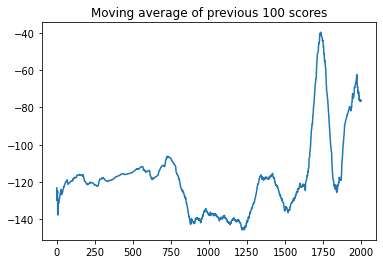

In [6]:
#     manage_memory()
env = gym.make('BipedalWalker-v3')
agent = Agent(inputShape=env.observation_space.shape, env=env,actionsNumber=env.action_space.shape[0], alpha=0.0001, beta=0.001)
gamesNumber = 2000

plotFile = 'plot_ddpg.png'

bestScore = env.reward_range[0]
historyScores = []
checkpoint = False

if checkpoint:
    agent.load()
    evaluate = True
    
else:
    evaluate = False

for i in range(gamesNumber):
    observation = env.reset()
    done = False
    score = 0
    while not done:
        action = agent.chooseAction(observation, evaluate)
        nextObservation, reward, done, info = env.step(action)
        score += reward
        agent.transition(observation, action, reward, nextObservation, done)
        if not checkpoint:
            agent.learn()
        observation = nextObservation

    historyScores.append(score)
    avgScore = np.mean(historyScores[-100:])

    if avgScore > bestScore:
        bestScore = avgScore
        if not checkpoint:
            agent.save()

    print('episode {} score {:.1f} avg score {:.1f}'.
          format(i, score, avgScore))

if not checkpoint:
    x = [i+1 for i in range(gamesNumber)]
    plot(x, historyScores, plotFile)

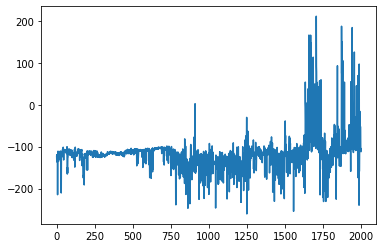

In [7]:
plt.plot(historyScores)
plt.show()

In [8]:
checkpoint = True

if checkpoint:
    agent.load()
    evaluate = True
    
else:
    evaluate = False

for i in range(1):
    observation = env.reset()
    done = False
    score = 0
    while not done:
        env.render()
        action = agent.chooseAction(observation, evaluate)
        nextObservation, reward, done, info = env.step(action)
        score += reward
        agent.transition(observation, action, reward, nextObservation, done)
        if not checkpoint:
            agent.learn()
        observation = nextObservation
    env.close()


load models


# Random Agent for BipedalWalker

episode 0 score -124.9 avg score -124.9
episode 1 score -85.9 avg score -105.4
episode 2 score -116.8 avg score -109.2
episode 3 score -89.2 avg score -104.2
episode 4 score -113.2 avg score -106.0
episode 5 score -90.0 avg score -103.3
episode 6 score -110.0 avg score -104.3
episode 7 score -81.1 avg score -101.4
episode 8 score -107.9 avg score -102.1
episode 9 score -79.7 avg score -99.9
episode 10 score -99.7 avg score -99.9
episode 11 score -112.2 avg score -100.9
episode 12 score -79.8 avg score -99.3
episode 13 score -123.9 avg score -101.0
episode 14 score -121.3 avg score -102.4
episode 15 score -99.7 avg score -102.2
episode 16 score -80.0 avg score -100.9
episode 17 score -119.3 avg score -101.9
episode 18 score -100.4 avg score -101.8
episode 19 score -104.7 avg score -102.0
episode 20 score -96.2 avg score -101.7
episode 21 score -93.2 avg score -101.3
episode 22 score -103.4 avg score -101.4
episode 23 score -121.8 avg score -102.3
episode 24 score -122.8 avg score -103.1

episode 206 score -88.9 avg score -101.8
episode 207 score -88.5 avg score -101.5
episode 208 score -85.4 avg score -101.4
episode 209 score -79.2 avg score -101.1
episode 210 score -79.5 avg score -101.0
episode 211 score -101.2 avg score -101.1
episode 212 score -116.4 avg score -101.1
episode 213 score -83.5 avg score -101.1
episode 214 score -74.7 avg score -100.7
episode 215 score -102.2 avg score -100.6
episode 216 score -73.3 avg score -100.5
episode 217 score -121.5 avg score -100.7
episode 218 score -84.4 avg score -100.5
episode 219 score -115.8 avg score -100.7
episode 220 score -83.9 avg score -100.5
episode 221 score -113.2 avg score -100.7
episode 222 score -83.5 avg score -100.6
episode 223 score -100.6 avg score -100.5
episode 224 score -79.6 avg score -100.1
episode 225 score -77.1 avg score -99.8
episode 226 score -99.6 avg score -99.7
episode 227 score -116.8 avg score -99.9
episode 228 score -83.0 avg score -99.7
episode 229 score -106.0 avg score -99.6
episode 230 

episode 415 score -83.7 avg score -99.8
episode 416 score -115.2 avg score -99.8
episode 417 score -115.0 avg score -99.8
episode 418 score -105.3 avg score -99.8
episode 419 score -118.0 avg score -100.0
episode 420 score -119.9 avg score -100.4
episode 421 score -104.9 avg score -100.3
episode 422 score -108.1 avg score -100.4
episode 423 score -123.1 avg score -100.6
episode 424 score -100.5 avg score -100.6
episode 425 score -91.8 avg score -100.8
episode 426 score -83.8 avg score -100.5
episode 427 score -82.7 avg score -100.2
episode 428 score -100.3 avg score -100.4
episode 429 score -81.9 avg score -100.3
episode 430 score -99.2 avg score -100.2
episode 431 score -106.4 avg score -100.4
episode 432 score -92.1 avg score -100.2
episode 433 score -105.2 avg score -100.4
episode 434 score -119.8 avg score -100.6
episode 435 score -84.0 avg score -100.4
episode 436 score -98.5 avg score -100.3
episode 437 score -114.6 avg score -100.6
episode 438 score -118.3 avg score -100.8
episo

episode 616 score -83.8 avg score -99.3
episode 617 score -75.1 avg score -99.3
episode 618 score -94.8 avg score -99.4
episode 619 score -100.3 avg score -99.5
episode 620 score -80.2 avg score -99.3
episode 621 score -90.1 avg score -99.0
episode 622 score -100.5 avg score -99.2
episode 623 score -85.6 avg score -98.7
episode 624 score -83.4 avg score -98.5
episode 625 score -112.0 avg score -98.7
episode 626 score -104.8 avg score -98.9
episode 627 score -114.3 avg score -99.3
episode 628 score -84.2 avg score -99.1
episode 629 score -79.2 avg score -98.4
episode 630 score -111.7 avg score -98.5
episode 631 score -74.5 avg score -98.4
episode 632 score -75.8 avg score -98.1
episode 633 score -85.2 avg score -97.8
episode 634 score -115.9 avg score -98.0
episode 635 score -112.5 avg score -98.1
episode 636 score -116.1 avg score -98.5
episode 637 score -76.8 avg score -98.4
episode 638 score -81.9 avg score -98.3
episode 639 score -118.2 avg score -98.5
episode 640 score -111.2 avg s

episode 822 score -102.7 avg score -99.2
episode 823 score -117.4 avg score -99.4
episode 824 score -108.1 avg score -99.7
episode 825 score -83.6 avg score -99.5
episode 826 score -77.1 avg score -99.3
episode 827 score -120.2 avg score -99.3
episode 828 score -107.0 avg score -99.1
episode 829 score -85.1 avg score -99.0
episode 830 score -101.6 avg score -99.0
episode 831 score -90.8 avg score -98.9
episode 832 score -114.0 avg score -99.1
episode 833 score -81.0 avg score -98.9
episode 834 score -101.4 avg score -98.8
episode 835 score -90.2 avg score -98.7
episode 836 score -117.5 avg score -99.0
episode 837 score -80.7 avg score -99.0
episode 838 score -103.8 avg score -98.9
episode 839 score -77.3 avg score -98.6
episode 840 score -82.9 avg score -98.4
episode 841 score -100.5 avg score -98.6
episode 842 score -107.5 avg score -99.0
episode 843 score -98.8 avg score -98.9
episode 844 score -85.4 avg score -98.8
episode 845 score -108.8 avg score -98.8
episode 846 score -107.6 av

episode 1031 score -84.4 avg score -100.4
episode 1032 score -109.6 avg score -100.5
episode 1033 score -116.1 avg score -100.8
episode 1034 score -77.5 avg score -100.5
episode 1035 score -114.5 avg score -100.6
episode 1036 score -110.3 avg score -100.8
episode 1037 score -78.9 avg score -100.7
episode 1038 score -79.4 avg score -100.7
episode 1039 score -101.1 avg score -100.7
episode 1040 score -99.1 avg score -100.6
episode 1041 score -110.3 avg score -100.6
episode 1042 score -99.2 avg score -100.4
episode 1043 score -91.0 avg score -100.3
episode 1044 score -115.2 avg score -100.4
episode 1045 score -101.9 avg score -100.2
episode 1046 score -109.4 avg score -100.4
episode 1047 score -97.2 avg score -100.5
episode 1048 score -85.1 avg score -100.4
episode 1049 score -113.5 avg score -100.5
episode 1050 score -98.8 avg score -100.8
episode 1051 score -101.6 avg score -100.6
episode 1052 score -99.6 avg score -100.6
episode 1053 score -98.0 avg score -100.8
episode 1054 score -105

episode 1230 score -72.4 avg score -98.4
episode 1231 score -90.1 avg score -98.3
episode 1232 score -93.9 avg score -98.4
episode 1233 score -110.7 avg score -98.7
episode 1234 score -119.1 avg score -99.0
episode 1235 score -81.9 avg score -98.8
episode 1236 score -103.0 avg score -99.1
episode 1237 score -95.7 avg score -99.3
episode 1238 score -101.1 avg score -99.3
episode 1239 score -102.8 avg score -99.2
episode 1240 score -99.1 avg score -99.3
episode 1241 score -80.1 avg score -99.1
episode 1242 score -101.4 avg score -98.9
episode 1243 score -114.0 avg score -99.0
episode 1244 score -97.7 avg score -98.8
episode 1245 score -74.5 avg score -98.6
episode 1246 score -100.0 avg score -98.4
episode 1247 score -99.2 avg score -98.4
episode 1248 score -119.2 avg score -98.4
episode 1249 score -121.7 avg score -98.6
episode 1250 score -79.3 avg score -98.4
episode 1251 score -103.3 avg score -98.3
episode 1252 score -85.3 avg score -98.1
episode 1253 score -101.1 avg score -98.0
epis

episode 1437 score -87.3 avg score -99.4
episode 1438 score -122.3 avg score -99.6
episode 1439 score -113.9 avg score -99.6
episode 1440 score -80.0 avg score -99.4
episode 1441 score -118.8 avg score -99.5
episode 1442 score -97.9 avg score -99.6
episode 1443 score -104.9 avg score -99.6
episode 1444 score -105.8 avg score -100.0
episode 1445 score -102.8 avg score -100.2
episode 1446 score -126.1 avg score -100.8
episode 1447 score -101.3 avg score -99.8
episode 1448 score -102.4 avg score -99.6
episode 1449 score -99.1 avg score -99.8
episode 1450 score -120.9 avg score -99.8
episode 1451 score -99.2 avg score -100.0
episode 1452 score -69.2 avg score -99.7
episode 1453 score -91.0 avg score -99.6
episode 1454 score -116.8 avg score -99.8
episode 1455 score -109.1 avg score -99.6
episode 1456 score -99.5 avg score -99.6
episode 1457 score -104.7 avg score -99.4
episode 1458 score -115.7 avg score -99.8
episode 1459 score -90.7 avg score -99.7
episode 1460 score -100.3 avg score -99

episode 1632 score -88.5 avg score -98.7
episode 1633 score -86.2 avg score -98.3
episode 1634 score -104.8 avg score -98.4
episode 1635 score -73.1 avg score -98.1
episode 1636 score -109.1 avg score -98.4
episode 1637 score -100.5 avg score -98.6
episode 1638 score -107.1 avg score -98.7
episode 1639 score -101.0 avg score -98.7
episode 1640 score -115.4 avg score -99.1
episode 1641 score -120.1 avg score -99.3
episode 1642 score -112.7 avg score -99.5
episode 1643 score -101.1 avg score -99.3
episode 1644 score -115.1 avg score -99.3
episode 1645 score -120.8 avg score -99.7
episode 1646 score -98.3 avg score -99.6
episode 1647 score -103.3 avg score -99.7
episode 1648 score -112.1 avg score -99.6
episode 1649 score -109.1 avg score -99.6
episode 1650 score -118.8 avg score -99.8
episode 1651 score -100.9 avg score -99.6
episode 1652 score -85.4 avg score -99.5
episode 1653 score -104.4 avg score -99.5
episode 1654 score -99.3 avg score -99.2
episode 1655 score -121.0 avg score -99.

episode 1836 score -88.7 avg score -102.4
episode 1837 score -80.2 avg score -102.4
episode 1838 score -109.9 avg score -102.4
episode 1839 score -74.2 avg score -102.2
episode 1840 score -122.4 avg score -102.4
episode 1841 score -115.1 avg score -102.6
episode 1842 score -108.3 avg score -102.4
episode 1843 score -101.3 avg score -102.3
episode 1844 score -105.3 avg score -102.1
episode 1845 score -100.5 avg score -102.1
episode 1846 score -105.0 avg score -102.1
episode 1847 score -101.0 avg score -102.3
episode 1848 score -118.3 avg score -102.4
episode 1849 score -101.9 avg score -102.2
episode 1850 score -80.3 avg score -102.0
episode 1851 score -77.8 avg score -101.8
episode 1852 score -86.3 avg score -101.6
episode 1853 score -98.0 avg score -101.6
episode 1854 score -99.8 avg score -101.9
episode 1855 score -76.3 avg score -101.9
episode 1856 score -120.0 avg score -102.3
episode 1857 score -101.3 avg score -102.2
episode 1858 score -103.8 avg score -102.4
episode 1859 score -

episode 2030 score -87.1 avg score -99.1
episode 2031 score -98.8 avg score -99.3
episode 2032 score -105.8 avg score -99.4
episode 2033 score -80.7 avg score -99.3
episode 2034 score -105.8 avg score -99.5
episode 2035 score -102.0 avg score -99.6
episode 2036 score -100.4 avg score -99.6
episode 2037 score -103.2 avg score -99.5
episode 2038 score -102.4 avg score -99.3
episode 2039 score -102.3 avg score -99.4
episode 2040 score -80.4 avg score -99.0
episode 2041 score -115.3 avg score -99.4
episode 2042 score -103.0 avg score -99.4
episode 2043 score -82.3 avg score -99.2
episode 2044 score -102.6 avg score -99.2
episode 2045 score -83.9 avg score -99.2
episode 2046 score -99.2 avg score -99.5
episode 2047 score -101.3 avg score -99.7
episode 2048 score -118.6 avg score -99.7
episode 2049 score -107.4 avg score -99.6
episode 2050 score -105.5 avg score -99.5
episode 2051 score -80.6 avg score -99.6
episode 2052 score -86.1 avg score -99.6
episode 2053 score -82.3 avg score -99.4
ep

episode 2233 score -84.9 avg score -98.0
episode 2234 score -110.7 avg score -98.1
episode 2235 score -81.1 avg score -98.1
episode 2236 score -116.8 avg score -98.3
episode 2237 score -103.8 avg score -98.3
episode 2238 score -101.3 avg score -98.5
episode 2239 score -104.7 avg score -98.4
episode 2240 score -107.5 avg score -98.2
episode 2241 score -100.0 avg score -98.4
episode 2242 score -98.2 avg score -98.2
episode 2243 score -81.4 avg score -98.2
episode 2244 score -110.0 avg score -98.4
episode 2245 score -101.6 avg score -98.7
episode 2246 score -86.3 avg score -98.6
episode 2247 score -79.4 avg score -98.4
episode 2248 score -101.1 avg score -98.4
episode 2249 score -103.0 avg score -98.5
episode 2250 score -99.8 avg score -98.7
episode 2251 score -82.8 avg score -98.7
episode 2252 score -100.4 avg score -98.8
episode 2253 score -80.5 avg score -98.6
episode 2254 score -83.3 avg score -98.4
episode 2255 score -83.4 avg score -98.4
episode 2256 score -99.6 avg score -98.4
epis

episode 2431 score -100.0 avg score -100.4
episode 2432 score -89.8 avg score -100.3
episode 2433 score -107.5 avg score -100.5
episode 2434 score -88.4 avg score -100.3
episode 2435 score -100.7 avg score -100.2
episode 2436 score -97.3 avg score -100.2
episode 2437 score -103.0 avg score -100.2
episode 2438 score -105.9 avg score -100.2
episode 2439 score -101.1 avg score -100.2
episode 2440 score -98.3 avg score -100.1
episode 2441 score -102.3 avg score -100.0
episode 2442 score -98.2 avg score -99.9
episode 2443 score -77.6 avg score -99.5
episode 2444 score -85.0 avg score -99.6
episode 2445 score -115.7 avg score -99.6
episode 2446 score -76.8 avg score -99.6
episode 2447 score -102.6 avg score -99.6
episode 2448 score -105.4 avg score -99.7
episode 2449 score -103.3 avg score -99.7
episode 2450 score -102.1 avg score -99.7
episode 2451 score -77.9 avg score -99.7
episode 2452 score -90.3 avg score -99.4
episode 2453 score -101.4 avg score -99.3
episode 2454 score -86.5 avg scor

episode 2628 score -110.2 avg score -97.8
episode 2629 score -79.9 avg score -97.5
episode 2630 score -122.3 avg score -98.0
episode 2631 score -112.1 avg score -98.0
episode 2632 score -115.3 avg score -98.2
episode 2633 score -107.1 avg score -98.0
episode 2634 score -122.0 avg score -98.3
episode 2635 score -100.6 avg score -98.3
episode 2636 score -83.3 avg score -98.1
episode 2637 score -120.3 avg score -98.2
episode 2638 score -119.7 avg score -98.4
episode 2639 score -79.7 avg score -98.0
episode 2640 score -79.4 avg score -97.8
episode 2641 score -114.4 avg score -98.0
episode 2642 score -88.9 avg score -97.8
episode 2643 score -81.0 avg score -97.5
episode 2644 score -95.7 avg score -97.5
episode 2645 score -117.7 avg score -97.6
episode 2646 score -105.0 avg score -97.9
episode 2647 score -85.7 avg score -97.8
episode 2648 score -81.4 avg score -97.8
episode 2649 score -199.2 avg score -98.8
episode 2650 score -104.5 avg score -99.0
episode 2651 score -96.7 avg score -99.1
ep

episode 2825 score -82.6 avg score -100.9
episode 2826 score -100.7 avg score -100.8
episode 2827 score -85.6 avg score -100.6
episode 2828 score -99.7 avg score -100.7
episode 2829 score -110.3 avg score -100.9
episode 2830 score -78.2 avg score -100.7
episode 2831 score -91.6 avg score -100.6
episode 2832 score -115.5 avg score -100.7
episode 2833 score -85.4 avg score -100.5
episode 2834 score -110.9 avg score -100.9
episode 2835 score -86.2 avg score -100.9
episode 2836 score -98.2 avg score -100.9
episode 2837 score -101.9 avg score -100.8
episode 2838 score -114.0 avg score -100.9
episode 2839 score -103.0 avg score -101.1
episode 2840 score -112.3 avg score -101.1
episode 2841 score -103.4 avg score -101.0
episode 2842 score -105.2 avg score -101.1
episode 2843 score -103.8 avg score -101.2
episode 2844 score -104.5 avg score -101.1
episode 2845 score -100.5 avg score -101.3
episode 2846 score -103.9 avg score -101.3
episode 2847 score -102.1 avg score -101.3
episode 2848 score 

episode 3021 score -112.5 avg score -99.4
episode 3022 score -87.6 avg score -99.2
episode 3023 score -79.2 avg score -98.9
episode 3024 score -116.4 avg score -99.1
episode 3025 score -112.7 avg score -99.5
episode 3026 score -121.5 avg score -99.6
episode 3027 score -101.9 avg score -99.6
episode 3028 score -113.5 avg score -99.7
episode 3029 score -97.1 avg score -99.6
episode 3030 score -105.9 avg score -99.9
episode 3031 score -79.9 avg score -99.7
episode 3032 score -85.7 avg score -99.4
episode 3033 score -97.7 avg score -99.4
episode 3034 score -103.3 avg score -99.3
episode 3035 score -105.9 avg score -99.3
episode 3036 score -116.3 avg score -99.6
episode 3037 score -101.2 avg score -99.5
episode 3038 score -109.4 avg score -99.6
episode 3039 score -99.1 avg score -99.8
episode 3040 score -83.1 avg score -99.7
episode 3041 score -80.2 avg score -99.5
episode 3042 score -101.1 avg score -99.5
episode 3043 score -76.8 avg score -99.3
episode 3044 score -103.8 avg score -99.2
ep

episode 3230 score -83.6 avg score -99.3
episode 3231 score -101.0 avg score -99.1
episode 3232 score -101.3 avg score -99.1
episode 3233 score -88.3 avg score -99.0
episode 3234 score -102.3 avg score -98.8
episode 3235 score -102.5 avg score -98.8
episode 3236 score -101.2 avg score -99.1
episode 3237 score -99.0 avg score -99.2
episode 3238 score -82.7 avg score -99.1
episode 3239 score -106.8 avg score -99.0
episode 3240 score -115.4 avg score -99.4
episode 3241 score -98.8 avg score -99.5
episode 3242 score -118.0 avg score -99.6
episode 3243 score -99.0 avg score -99.6
episode 3244 score -121.2 avg score -99.8
episode 3245 score -116.5 avg score -99.7
episode 3246 score -111.2 avg score -99.7
episode 3247 score -97.9 avg score -99.7
episode 3248 score -101.0 avg score -99.8
episode 3249 score -99.3 avg score -99.7
episode 3250 score -105.1 avg score -99.6
episode 3251 score -119.1 avg score -99.6
episode 3252 score -92.4 avg score -99.7
episode 3253 score -118.4 avg score -99.8
e

episode 3424 score -91.3 avg score -100.8
episode 3425 score -111.9 avg score -100.8
episode 3426 score -81.2 avg score -100.9
episode 3427 score -95.7 avg score -101.1
episode 3428 score -104.6 avg score -101.1
episode 3429 score -86.6 avg score -100.9
episode 3430 score -112.1 avg score -100.9
episode 3431 score -114.3 avg score -100.9
episode 3432 score -118.0 avg score -101.0
episode 3433 score -90.5 avg score -100.9
episode 3434 score -89.1 avg score -100.7
episode 3435 score -78.1 avg score -100.3
episode 3436 score -102.3 avg score -100.3
episode 3437 score -91.0 avg score -100.4
episode 3438 score -80.1 avg score -100.4
episode 3439 score -78.7 avg score -100.1
episode 3440 score -102.1 avg score -100.2
episode 3441 score -83.3 avg score -100.0
episode 3442 score -103.1 avg score -100.0
episode 3443 score -85.7 avg score -99.7
episode 3444 score -99.0 avg score -99.9
episode 3445 score -107.1 avg score -99.9
episode 3446 score -106.4 avg score -99.9
episode 3447 score -114.7 av

episode 3619 score -79.7 avg score -100.8
episode 3620 score -86.4 avg score -100.7
episode 3621 score -111.4 avg score -100.8
episode 3622 score -99.1 avg score -101.0
episode 3623 score -111.1 avg score -101.1
episode 3624 score -109.8 avg score -101.1
episode 3625 score -122.6 avg score -101.5
episode 3626 score -100.2 avg score -101.4
episode 3627 score -77.7 avg score -101.0
episode 3628 score -86.4 avg score -100.8
episode 3629 score -120.7 avg score -101.2
episode 3630 score -104.8 avg score -101.3
episode 3631 score -101.3 avg score -101.2
episode 3632 score -101.4 avg score -101.3
episode 3633 score -102.1 avg score -101.3
episode 3634 score -109.9 avg score -101.7
episode 3635 score -97.1 avg score -101.5
episode 3636 score -80.7 avg score -101.1
episode 3637 score -85.9 avg score -101.0
episode 3638 score -105.2 avg score -101.0
episode 3639 score -127.1 avg score -101.1
episode 3640 score -99.5 avg score -101.3
episode 3641 score -118.6 avg score -101.8
episode 3642 score -

episode 3819 score -91.2 avg score -98.3
episode 3820 score -101.4 avg score -98.5
episode 3821 score -77.1 avg score -98.2
episode 3822 score -80.4 avg score -98.1
episode 3823 score -78.7 avg score -98.0
episode 3824 score -79.2 avg score -97.7
episode 3825 score -99.3 avg score -97.9
episode 3826 score -115.8 avg score -98.0
episode 3827 score -87.7 avg score -97.9
episode 3828 score -100.7 avg score -98.2
episode 3829 score -97.8 avg score -98.1
episode 3830 score -95.3 avg score -98.0
episode 3831 score -108.0 avg score -98.1
episode 3832 score -99.9 avg score -98.1
episode 3833 score -99.0 avg score -98.1
episode 3834 score -113.8 avg score -98.4
episode 3835 score -75.1 avg score -98.4
episode 3836 score -112.7 avg score -98.5
episode 3837 score -91.9 avg score -98.3
episode 3838 score -100.6 avg score -98.1
episode 3839 score -102.0 avg score -98.0
episode 3840 score -99.4 avg score -97.9
episode 3841 score -102.5 avg score -98.2
episode 3842 score -100.6 avg score -98.4
episod

episode 4016 score -119.7 avg score -101.4
episode 4017 score -106.7 avg score -100.8
episode 4018 score -103.1 avg score -101.0
episode 4019 score -102.1 avg score -101.3
episode 4020 score -120.1 avg score -101.3
episode 4021 score -102.6 avg score -101.2
episode 4022 score -109.1 avg score -101.2
episode 4023 score -110.9 avg score -101.5
episode 4024 score -79.8 avg score -101.5
episode 4025 score -102.4 avg score -101.5
episode 4026 score -103.8 avg score -101.3
episode 4027 score -102.9 avg score -101.5
episode 4028 score -107.5 avg score -101.4
episode 4029 score -76.9 avg score -101.2
episode 4030 score -82.3 avg score -100.9
episode 4031 score -103.1 avg score -100.8
episode 4032 score -102.7 avg score -101.0
episode 4033 score -74.7 avg score -100.8
episode 4034 score -105.3 avg score -101.0
episode 4035 score -96.9 avg score -101.0
episode 4036 score -114.6 avg score -100.9
episode 4037 score -82.8 avg score -100.6
episode 4038 score -114.3 avg score -101.0
episode 4039 scor

episode 4213 score -92.0 avg score -101.7
episode 4214 score -111.7 avg score -101.8
episode 4215 score -88.8 avg score -101.5
episode 4216 score -101.3 avg score -101.4
episode 4217 score -86.4 avg score -101.5
episode 4218 score -103.8 avg score -101.5
episode 4219 score -89.1 avg score -101.4
episode 4220 score -100.5 avg score -101.6
episode 4221 score -101.9 avg score -101.6
episode 4222 score -100.2 avg score -101.5
episode 4223 score -102.2 avg score -101.2
episode 4224 score -88.6 avg score -101.2
episode 4225 score -82.2 avg score -101.0
episode 4226 score -96.0 avg score -100.9
episode 4227 score -112.8 avg score -100.8
episode 4228 score -89.4 avg score -100.6
episode 4229 score -117.0 avg score -101.0
episode 4230 score -101.5 avg score -100.7
episode 4231 score -79.2 avg score -100.6
episode 4232 score -79.9 avg score -100.4
episode 4233 score -88.2 avg score -100.2
episode 4234 score -77.1 avg score -100.0
episode 4235 score -110.9 avg score -100.1
episode 4236 score -90.

episode 4410 score -82.6 avg score -97.6
episode 4411 score -85.7 avg score -97.4
episode 4412 score -98.5 avg score -97.4
episode 4413 score -83.3 avg score -97.2
episode 4414 score -78.4 avg score -96.8
episode 4415 score -100.0 avg score -97.0
episode 4416 score -101.8 avg score -97.3
episode 4417 score -88.8 avg score -97.2
episode 4418 score -113.7 avg score -97.5
episode 4419 score -113.0 avg score -97.8
episode 4420 score -83.3 avg score -97.8
episode 4421 score -98.8 avg score -98.0
episode 4422 score -98.9 avg score -97.8
episode 4423 score -98.2 avg score -98.0
episode 4424 score -77.7 avg score -97.9
episode 4425 score -123.7 avg score -98.1
episode 4426 score -99.4 avg score -98.2
episode 4427 score -113.0 avg score -98.5
episode 4428 score -125.6 avg score -98.9
episode 4429 score -89.9 avg score -99.1
episode 4430 score -74.6 avg score -98.8
episode 4431 score -98.1 avg score -98.9
episode 4432 score -99.6 avg score -99.1
episode 4433 score -99.0 avg score -99.0
episode 4

episode 4610 score -79.7 avg score -98.3
episode 4611 score -105.6 avg score -98.3
episode 4612 score -103.3 avg score -98.4
episode 4613 score -84.9 avg score -98.1
episode 4614 score -111.9 avg score -98.3
episode 4615 score -82.8 avg score -98.1
episode 4616 score -103.0 avg score -98.0
episode 4617 score -113.7 avg score -98.4
episode 4618 score -84.4 avg score -98.4
episode 4619 score -85.1 avg score -98.2
episode 4620 score -97.6 avg score -98.4
episode 4621 score -102.4 avg score -98.3
episode 4622 score -97.2 avg score -98.4
episode 4623 score -104.5 avg score -98.5
episode 4624 score -99.4 avg score -98.7
episode 4625 score -83.2 avg score -98.3
episode 4626 score -106.3 avg score -98.4
episode 4627 score -107.1 avg score -98.4
episode 4628 score -77.2 avg score -98.0
episode 4629 score -100.5 avg score -98.0
episode 4630 score -85.8 avg score -97.8
episode 4631 score -96.0 avg score -97.8
episode 4632 score -97.1 avg score -97.7
episode 4633 score -84.9 avg score -97.6
episod

episode 4812 score -81.8 avg score -98.6
episode 4813 score -78.5 avg score -98.4
episode 4814 score -121.0 avg score -98.6
episode 4815 score -114.1 avg score -98.9
episode 4816 score -121.4 avg score -99.1
episode 4817 score -103.4 avg score -99.0
episode 4818 score -94.5 avg score -98.8
episode 4819 score -102.5 avg score -98.8
episode 4820 score -113.0 avg score -98.9
episode 4821 score -101.7 avg score -98.9
episode 4822 score -100.9 avg score -98.8
episode 4823 score -112.8 avg score -98.9
episode 4824 score -93.4 avg score -98.6
episode 4825 score -101.3 avg score -98.5
episode 4826 score -79.9 avg score -98.5
episode 4827 score -97.0 avg score -98.6
episode 4828 score -102.2 avg score -98.7
episode 4829 score -82.1 avg score -98.3
episode 4830 score -82.9 avg score -98.1
episode 4831 score -83.6 avg score -98.0
episode 4832 score -101.8 avg score -97.9
episode 4833 score -84.1 avg score -97.9
episode 4834 score -109.7 avg score -98.0
episode 4835 score -103.3 avg score -98.0
ep

episode 5016 score -79.8 avg score -101.4
episode 5017 score -116.9 avg score -101.5
episode 5018 score -83.1 avg score -101.6
episode 5019 score -111.6 avg score -101.9
episode 5020 score -112.8 avg score -101.9
episode 5021 score -79.9 avg score -102.0
episode 5022 score -104.5 avg score -102.1
episode 5023 score -114.6 avg score -102.2
episode 5024 score -89.3 avg score -102.0
episode 5025 score -101.8 avg score -102.2
episode 5026 score -117.2 avg score -102.2
episode 5027 score -73.5 avg score -101.8
episode 5028 score -83.2 avg score -101.5
episode 5029 score -104.0 avg score -101.7
episode 5030 score -73.5 avg score -101.3
episode 5031 score -85.4 avg score -101.4
episode 5032 score -104.6 avg score -101.3
episode 5033 score -80.6 avg score -101.0
episode 5034 score -84.2 avg score -100.6
episode 5035 score -119.6 avg score -100.7
episode 5036 score -88.2 avg score -100.3
episode 5037 score -97.6 avg score -100.1
episode 5038 score -113.2 avg score -100.2
episode 5039 score -98.

episode 5212 score -78.7 avg score -99.3
episode 5213 score -118.6 avg score -99.3
episode 5214 score -115.0 avg score -99.4
episode 5215 score -118.4 avg score -99.4
episode 5216 score -81.9 avg score -99.0
episode 5217 score -105.8 avg score -99.0
episode 5218 score -139.6 avg score -99.3
episode 5219 score -103.7 avg score -99.6
episode 5220 score -113.2 avg score -99.4
episode 5221 score -100.7 avg score -99.5
episode 5222 score -116.7 avg score -99.4
episode 5223 score -94.8 avg score -99.3
episode 5224 score -99.4 avg score -99.1
episode 5225 score -105.0 avg score -99.4
episode 5226 score -113.4 avg score -99.6
episode 5227 score -112.6 avg score -99.8
episode 5228 score -118.9 avg score -100.2
episode 5229 score -103.9 avg score -100.2
episode 5230 score -114.8 avg score -100.3
episode 5231 score -75.6 avg score -100.0
episode 5232 score -90.6 avg score -100.1
episode 5233 score -104.2 avg score -99.9
episode 5234 score -105.5 avg score -99.8
episode 5235 score -110.1 avg score

episode 5409 score -86.2 avg score -98.8
episode 5410 score -106.3 avg score -99.1
episode 5411 score -131.1 avg score -99.4
episode 5412 score -121.5 avg score -99.5
episode 5413 score -106.5 avg score -99.4
episode 5414 score -83.7 avg score -99.6
episode 5415 score -120.1 avg score -99.7
episode 5416 score -113.7 avg score -100.1
episode 5417 score -116.1 avg score -100.2
episode 5418 score -102.5 avg score -100.5
episode 5419 score -83.1 avg score -100.1
episode 5420 score -120.3 avg score -100.3
episode 5421 score -111.1 avg score -100.6
episode 5422 score -109.1 avg score -100.9
episode 5423 score -112.4 avg score -101.0
episode 5424 score -112.8 avg score -101.0
episode 5425 score -107.5 avg score -101.3
episode 5426 score -76.6 avg score -101.0
episode 5427 score -88.7 avg score -101.1
episode 5428 score -101.8 avg score -101.1
episode 5429 score -83.5 avg score -101.0
episode 5430 score -77.0 avg score -100.9
episode 5431 score -100.4 avg score -100.9
episode 5432 score -80.9 

episode 5603 score -90.9 avg score -101.0
episode 5604 score -98.9 avg score -101.1
episode 5605 score -111.9 avg score -101.5
episode 5606 score -79.4 avg score -101.1
episode 5607 score -99.3 avg score -101.1
episode 5608 score -114.6 avg score -101.3
episode 5609 score -110.7 avg score -101.2
episode 5610 score -89.2 avg score -101.1
episode 5611 score -100.2 avg score -101.1
episode 5612 score -98.8 avg score -101.0
episode 5613 score -101.6 avg score -100.9
episode 5614 score -87.3 avg score -101.0
episode 5615 score -101.8 avg score -101.2
episode 5616 score -114.9 avg score -101.2
episode 5617 score -101.6 avg score -101.1
episode 5618 score -76.8 avg score -100.8
episode 5619 score -109.7 avg score -100.9
episode 5620 score -101.4 avg score -100.8
episode 5621 score -103.4 avg score -100.8
episode 5622 score -98.8 avg score -100.9
episode 5623 score -108.5 avg score -100.9
episode 5624 score -98.1 avg score -100.8
episode 5625 score -87.4 avg score -100.6
episode 5626 score -10

episode 5809 score -79.9 avg score -98.7
episode 5810 score -99.8 avg score -98.9
episode 5811 score -105.2 avg score -99.1
episode 5812 score -106.8 avg score -99.0
episode 5813 score -91.6 avg score -98.7
episode 5814 score -103.0 avg score -98.8
episode 5815 score -78.6 avg score -98.4
episode 5816 score -86.6 avg score -98.2
episode 5817 score -90.4 avg score -98.3
episode 5818 score -115.3 avg score -98.4
episode 5819 score -102.9 avg score -98.3
episode 5820 score -104.1 avg score -98.1
episode 5821 score -85.4 avg score -98.0
episode 5822 score -99.4 avg score -98.1
episode 5823 score -116.0 avg score -98.1
episode 5824 score -102.2 avg score -98.3
episode 5825 score -103.9 avg score -98.5
episode 5826 score -79.8 avg score -98.3
episode 5827 score -115.0 avg score -98.6
episode 5828 score -100.1 avg score -98.6
episode 5829 score -109.3 avg score -98.8
episode 5830 score -101.6 avg score -99.0
episode 5831 score -102.1 avg score -99.0
episode 5832 score -104.5 avg score -99.0
e

episode 6007 score -80.7 avg score -99.4
episode 6008 score -101.1 avg score -99.5
episode 6009 score -187.7 avg score -100.3
episode 6010 score -115.6 avg score -100.4
episode 6011 score -124.5 avg score -100.6
episode 6012 score -106.3 avg score -100.6
episode 6013 score -79.0 avg score -100.4
episode 6014 score -108.2 avg score -100.4
episode 6015 score -99.7 avg score -100.7
episode 6016 score -82.2 avg score -100.4
episode 6017 score -104.9 avg score -100.6
episode 6018 score -104.1 avg score -100.8
episode 6019 score -118.7 avg score -100.9
episode 6020 score -113.7 avg score -100.9
episode 6021 score -114.1 avg score -101.3
episode 6022 score -115.3 avg score -101.7
episode 6023 score -101.5 avg score -101.9
episode 6024 score -112.0 avg score -102.0
episode 6025 score -100.2 avg score -102.0
episode 6026 score -118.6 avg score -102.3
episode 6027 score -78.5 avg score -102.1
episode 6028 score -77.8 avg score -102.0
episode 6029 score -104.3 avg score -101.9
episode 6030 score 

episode 6205 score -94.0 avg score -97.6
episode 6206 score -98.3 avg score -97.6
episode 6207 score -108.6 avg score -97.7
episode 6208 score -101.1 avg score -97.6
episode 6209 score -103.4 avg score -97.7
episode 6210 score -91.0 avg score -97.7
episode 6211 score -105.4 avg score -97.9
episode 6212 score -127.1 avg score -98.4
episode 6213 score -119.2 avg score -98.5
episode 6214 score -122.4 avg score -98.6
episode 6215 score -106.4 avg score -98.7
episode 6216 score -78.8 avg score -98.5
episode 6217 score -80.4 avg score -98.1
episode 6218 score -101.8 avg score -98.1
episode 6219 score -105.1 avg score -98.0
episode 6220 score -121.8 avg score -98.2
episode 6221 score -91.2 avg score -98.2
episode 6222 score -110.1 avg score -98.5
episode 6223 score -88.6 avg score -98.4
episode 6224 score -75.7 avg score -98.1
episode 6225 score -103.0 avg score -98.1
episode 6226 score -82.3 avg score -97.7
episode 6227 score -104.9 avg score -97.8
episode 6228 score -113.3 avg score -98.0
e

episode 6408 score -87.8 avg score -99.9
episode 6409 score -94.8 avg score -99.8
episode 6410 score -100.4 avg score -99.8
episode 6411 score -87.9 avg score -99.6
episode 6412 score -106.6 avg score -99.7
episode 6413 score -102.6 avg score -100.0
episode 6414 score -100.4 avg score -100.0
episode 6415 score -81.2 avg score -99.7
episode 6416 score -79.4 avg score -99.5
episode 6417 score -100.6 avg score -99.7
episode 6418 score -101.9 avg score -99.6
episode 6419 score -87.4 avg score -99.4
episode 6420 score -98.9 avg score -99.3
episode 6421 score -99.7 avg score -99.5
episode 6422 score -79.5 avg score -99.1
episode 6423 score -84.5 avg score -98.9
episode 6424 score -101.8 avg score -98.7
episode 6425 score -107.2 avg score -98.9
episode 6426 score -92.3 avg score -99.0
episode 6427 score -104.7 avg score -99.0
episode 6428 score -112.6 avg score -99.1
episode 6429 score -82.0 avg score -98.9
episode 6430 score -83.8 avg score -98.9
episode 6431 score -108.0 avg score -99.2
epi

episode 6605 score -81.3 avg score -102.5
episode 6606 score -83.4 avg score -102.5
episode 6607 score -116.2 avg score -102.5
episode 6608 score -86.5 avg score -102.2
episode 6609 score -122.4 avg score -102.4
episode 6610 score -102.0 avg score -102.4
episode 6611 score -111.6 avg score -102.7
episode 6612 score -89.3 avg score -102.5
episode 6613 score -85.4 avg score -102.3
episode 6614 score -77.2 avg score -102.0
episode 6615 score -102.1 avg score -102.0
episode 6616 score -75.6 avg score -101.5
episode 6617 score -93.8 avg score -101.4
episode 6618 score -74.9 avg score -101.2
episode 6619 score -114.5 avg score -101.2
episode 6620 score -101.5 avg score -101.2
episode 6621 score -111.9 avg score -101.4
episode 6622 score -104.0 avg score -101.6
episode 6623 score -106.7 avg score -101.7
episode 6624 score -78.7 avg score -101.7
episode 6625 score -102.7 avg score -101.8
episode 6626 score -102.8 avg score -101.8
episode 6627 score -117.9 avg score -101.8
episode 6628 score -7

episode 6808 score -71.9 avg score -101.2
episode 6809 score -87.6 avg score -101.1
episode 6810 score -100.6 avg score -101.1
episode 6811 score -100.6 avg score -101.2
episode 6812 score -100.4 avg score -101.2
episode 6813 score -121.3 avg score -101.3
episode 6814 score -81.0 avg score -101.0
episode 6815 score -75.5 avg score -100.8
episode 6816 score -89.1 avg score -100.6
episode 6817 score -99.4 avg score -100.8
episode 6818 score -119.7 avg score -101.0
episode 6819 score -103.2 avg score -101.0
episode 6820 score -73.5 avg score -100.7
episode 6821 score -80.2 avg score -100.5
episode 6822 score -82.5 avg score -100.5
episode 6823 score -101.1 avg score -100.7
episode 6824 score -121.2 avg score -100.9
episode 6825 score -101.4 avg score -100.9
episode 6826 score -99.6 avg score -100.9
episode 6827 score -101.5 avg score -100.9
episode 6828 score -101.0 avg score -100.6
episode 6829 score -99.8 avg score -100.4
episode 6830 score -101.8 avg score -100.6
episode 6831 score -11

episode 7007 score -78.9 avg score -99.0
episode 7008 score -101.1 avg score -99.1
episode 7009 score -115.7 avg score -99.1
episode 7010 score -75.0 avg score -98.8
episode 7011 score -101.8 avg score -98.8
episode 7012 score -100.1 avg score -98.8
episode 7013 score -100.2 avg score -99.1
episode 7014 score -84.6 avg score -99.2
episode 7015 score -84.2 avg score -99.0
episode 7016 score -113.5 avg score -99.1
episode 7017 score -114.8 avg score -99.4
episode 7018 score -93.8 avg score -99.6
episode 7019 score -87.3 avg score -99.4
episode 7020 score -98.5 avg score -99.7
episode 7021 score -105.2 avg score -99.8
episode 7022 score -97.8 avg score -99.7
episode 7023 score -100.5 avg score -99.5
episode 7024 score -115.7 avg score -99.7
episode 7025 score -105.0 avg score -99.7
episode 7026 score -81.3 avg score -99.3
episode 7027 score -105.3 avg score -99.3
episode 7028 score -83.4 avg score -99.2
episode 7029 score -107.5 avg score -99.2
episode 7030 score -79.1 avg score -99.0
epi

episode 7210 score -118.9 avg score -97.4
episode 7211 score -120.7 avg score -97.7
episode 7212 score -71.6 avg score -97.2
episode 7213 score -77.5 avg score -97.0
episode 7214 score -108.7 avg score -96.9
episode 7215 score -102.6 avg score -97.0
episode 7216 score -99.2 avg score -97.2
episode 7217 score -78.0 avg score -96.8
episode 7218 score -80.7 avg score -96.6
episode 7219 score -92.3 avg score -96.5
episode 7220 score -121.0 avg score -96.5
episode 7221 score -85.0 avg score -96.2
episode 7222 score -105.4 avg score -96.4
episode 7223 score -77.5 avg score -96.1
episode 7224 score -114.8 avg score -96.1
episode 7225 score -82.5 avg score -96.0
episode 7226 score -101.8 avg score -96.2
episode 7227 score -115.9 avg score -96.4
episode 7228 score -103.9 avg score -96.4
episode 7229 score -99.7 avg score -96.4
episode 7230 score -84.1 avg score -96.2
episode 7231 score -82.0 avg score -96.3
episode 7232 score -80.3 avg score -96.1
episode 7233 score -99.7 avg score -96.1
episod

episode 7407 score -85.8 avg score -98.9
episode 7408 score -105.2 avg score -98.8
episode 7409 score -84.1 avg score -98.9
episode 7410 score -102.6 avg score -98.9
episode 7411 score -113.1 avg score -99.0
episode 7412 score -117.2 avg score -99.4
episode 7413 score -91.0 avg score -99.1
episode 7414 score -98.9 avg score -98.9
episode 7415 score -96.7 avg score -98.7
episode 7416 score -85.0 avg score -98.5
episode 7417 score -122.5 avg score -98.6
episode 7418 score -85.9 avg score -98.6
episode 7419 score -85.5 avg score -98.4
episode 7420 score -125.0 avg score -98.9
episode 7421 score -102.9 avg score -98.8
episode 7422 score -99.7 avg score -98.7
episode 7423 score -104.1 avg score -98.7
episode 7424 score -91.3 avg score -98.6
episode 7425 score -118.3 avg score -98.7
episode 7426 score -117.0 avg score -98.8
episode 7427 score -118.6 avg score -99.0
episode 7428 score -130.7 avg score -99.3
episode 7429 score -85.5 avg score -99.2
episode 7430 score -85.0 avg score -99.0
epis

episode 7606 score -85.0 avg score -98.7
episode 7607 score -89.2 avg score -98.8
episode 7608 score -102.3 avg score -98.8
episode 7609 score -104.8 avg score -98.8
episode 7610 score -103.2 avg score -98.9
episode 7611 score -100.7 avg score -99.1
episode 7612 score -110.2 avg score -99.2
episode 7613 score -75.5 avg score -98.8
episode 7614 score -98.1 avg score -99.0
episode 7615 score -112.8 avg score -99.0
episode 7616 score -98.7 avg score -98.9
episode 7617 score -109.8 avg score -99.3
episode 7618 score -100.2 avg score -99.4
episode 7619 score -99.8 avg score -99.4
episode 7620 score -83.4 avg score -99.4
episode 7621 score -79.8 avg score -99.2
episode 7622 score -119.9 avg score -99.4
episode 7623 score -106.5 avg score -99.4
episode 7624 score -86.8 avg score -99.3
episode 7625 score -100.7 avg score -99.5
episode 7626 score -73.8 avg score -99.2
episode 7627 score -114.2 avg score -99.2
episode 7628 score -105.9 avg score -99.2
episode 7629 score -101.1 avg score -99.2
ep

episode 7821 score -117.1 avg score -100.6
episode 7822 score -101.0 avg score -100.9
episode 7823 score -100.7 avg score -101.1
episode 7824 score -77.3 avg score -101.0
episode 7825 score -100.3 avg score -100.9
episode 7826 score -109.8 avg score -101.0
episode 7827 score -129.8 avg score -101.3
episode 7828 score -100.7 avg score -101.3
episode 7829 score -102.1 avg score -101.3
episode 7830 score -81.3 avg score -101.0
episode 7831 score -74.2 avg score -100.7
episode 7832 score -114.1 avg score -101.1
episode 7833 score -117.4 avg score -101.5
episode 7834 score -80.9 avg score -101.3
episode 7835 score -84.0 avg score -101.4
episode 7836 score -91.5 avg score -101.1
episode 7837 score -99.8 avg score -101.0
episode 7838 score -100.7 avg score -100.8
episode 7839 score -96.7 avg score -101.0
episode 7840 score -70.3 avg score -100.6
episode 7841 score -104.5 avg score -100.5
episode 7842 score -86.0 avg score -100.4
episode 7843 score -103.7 avg score -100.3
episode 7844 score -9

episode 8029 score -90.9 avg score -98.7
episode 8030 score -79.8 avg score -98.5
episode 8031 score -81.4 avg score -98.5
episode 8032 score -100.2 avg score -98.4
episode 8033 score -98.2 avg score -98.4
episode 8034 score -114.1 avg score -98.4
episode 8035 score -102.0 avg score -98.3
episode 8036 score -103.3 avg score -98.5
episode 8037 score -83.3 avg score -98.3
episode 8038 score -109.7 avg score -98.2
episode 8039 score -120.2 avg score -98.4
episode 8040 score -89.3 avg score -98.0
episode 8041 score -75.1 avg score -97.6
episode 8042 score -111.0 avg score -97.9
episode 8043 score -80.6 avg score -97.7
episode 8044 score -88.0 avg score -97.7
episode 8045 score -98.5 avg score -97.7
episode 8046 score -117.2 avg score -97.9
episode 8047 score -88.0 avg score -97.6
episode 8048 score -101.0 avg score -97.6
episode 8049 score -102.4 avg score -97.8
episode 8050 score -115.4 avg score -98.0
episode 8051 score -99.2 avg score -98.2
episode 8052 score -81.5 avg score -98.3
episo

episode 8229 score -77.5 avg score -98.0
episode 8230 score -99.7 avg score -98.0
episode 8231 score -80.5 avg score -97.8
episode 8232 score -104.9 avg score -97.8
episode 8233 score -79.4 avg score -97.8
episode 8234 score -104.4 avg score -98.0
episode 8235 score -107.7 avg score -98.1
episode 8236 score -78.3 avg score -97.7
episode 8237 score -106.8 avg score -97.9
episode 8238 score -103.4 avg score -97.9
episode 8239 score -105.8 avg score -98.1
episode 8240 score -101.7 avg score -98.1
episode 8241 score -104.7 avg score -98.3
episode 8242 score -71.4 avg score -98.0
episode 8243 score -72.9 avg score -97.6
episode 8244 score -101.4 avg score -97.8
episode 8245 score -111.8 avg score -97.9
episode 8246 score -114.9 avg score -98.2
episode 8247 score -84.6 avg score -98.1
episode 8248 score -99.6 avg score -98.3
episode 8249 score -98.9 avg score -98.3
episode 8250 score -98.5 avg score -98.3
episode 8251 score -98.4 avg score -98.3
episode 8252 score -105.8 avg score -98.2
epis

episode 8432 score -84.3 avg score -95.3
episode 8433 score -101.0 avg score -95.3
episode 8434 score -98.8 avg score -95.1
episode 8435 score -102.7 avg score -95.3
episode 8436 score -104.7 avg score -95.6
episode 8437 score -75.2 avg score -95.3
episode 8438 score -103.7 avg score -95.6
episode 8439 score -101.3 avg score -95.8
episode 8440 score -104.3 avg score -95.8
episode 8441 score -109.1 avg score -95.7
episode 8442 score -112.7 avg score -95.8
episode 8443 score -101.2 avg score -96.0
episode 8444 score -103.8 avg score -96.3
episode 8445 score -112.2 avg score -96.4
episode 8446 score -105.3 avg score -96.4
episode 8447 score -103.7 avg score -96.5
episode 8448 score -83.8 avg score -96.3
episode 8449 score -84.1 avg score -96.0
episode 8450 score -86.3 avg score -96.1
episode 8451 score -115.7 avg score -96.2
episode 8452 score -112.8 avg score -96.2
episode 8453 score -118.7 avg score -96.5
episode 8454 score -100.3 avg score -96.5
episode 8455 score -89.3 avg score -96.6

episode 8631 score -79.8 avg score -99.2
episode 8632 score -78.4 avg score -98.9
episode 8633 score -99.5 avg score -98.9
episode 8634 score -108.7 avg score -99.2
episode 8635 score -73.1 avg score -98.9
episode 8636 score -100.4 avg score -98.9
episode 8637 score -83.8 avg score -98.6
episode 8638 score -105.0 avg score -98.8
episode 8639 score -75.8 avg score -98.6
episode 8640 score -81.3 avg score -98.6
episode 8641 score -110.2 avg score -98.6
episode 8642 score -97.7 avg score -98.5
episode 8643 score -100.9 avg score -98.3
episode 8644 score -110.7 avg score -98.3
episode 8645 score -108.7 avg score -98.3
episode 8646 score -109.2 avg score -98.5
episode 8647 score -106.2 avg score -98.6
episode 8648 score -104.9 avg score -98.5
episode 8649 score -67.9 avg score -98.4
episode 8650 score -111.0 avg score -98.6
episode 8651 score -81.6 avg score -98.4
episode 8652 score -100.5 avg score -98.6
episode 8653 score -104.2 avg score -98.8
episode 8654 score -120.2 avg score -98.8
ep

episode 8829 score -87.4 avg score -97.4
episode 8830 score -76.4 avg score -97.3
episode 8831 score -77.9 avg score -97.1
episode 8832 score -102.9 avg score -96.9
episode 8833 score -102.3 avg score -97.1
episode 8834 score -77.7 avg score -97.0
episode 8835 score -81.2 avg score -97.0
episode 8836 score -105.0 avg score -97.1
episode 8837 score -115.6 avg score -97.4
episode 8838 score -114.5 avg score -97.6
episode 8839 score -105.7 avg score -97.7
episode 8840 score -113.2 avg score -98.0
episode 8841 score -98.4 avg score -98.0
episode 8842 score -101.0 avg score -97.8
episode 8843 score -90.1 avg score -97.8
episode 8844 score -100.3 avg score -97.9
episode 8845 score -78.8 avg score -97.8
episode 8846 score -113.2 avg score -97.9
episode 8847 score -116.6 avg score -98.1
episode 8848 score -84.7 avg score -97.9
episode 8849 score -99.0 avg score -98.1
episode 8850 score -100.5 avg score -98.0
episode 8851 score -80.5 avg score -97.6
episode 8852 score -99.5 avg score -97.8
epis

episode 9040 score -78.3 avg score -99.4
episode 9041 score -112.3 avg score -99.8
episode 9042 score -101.6 avg score -99.9
episode 9043 score -83.9 avg score -99.7
episode 9044 score -101.2 avg score -99.5
episode 9045 score -82.3 avg score -99.3
episode 9046 score -101.5 avg score -99.4
episode 9047 score -105.2 avg score -99.5
episode 9048 score -102.0 avg score -99.6
episode 9049 score -85.5 avg score -99.7
episode 9050 score -105.7 avg score -99.6
episode 9051 score -100.7 avg score -99.5
episode 9052 score -83.3 avg score -99.5
episode 9053 score -105.3 avg score -99.4
episode 9054 score -96.8 avg score -99.2
episode 9055 score -88.4 avg score -98.9
episode 9056 score -99.5 avg score -98.8
episode 9057 score -100.5 avg score -98.8
episode 9058 score -101.1 avg score -98.7
episode 9059 score -112.0 avg score -98.8
episode 9060 score -110.5 avg score -98.9
episode 9061 score -102.6 avg score -99.1
episode 9062 score -102.1 avg score -99.0
episode 9063 score -102.8 avg score -99.3


episode 9244 score -89.9 avg score -101.2
episode 9245 score -111.7 avg score -101.2
episode 9246 score -127.3 avg score -101.4
episode 9247 score -100.1 avg score -101.3
episode 9248 score -85.1 avg score -101.0
episode 9249 score -107.6 avg score -101.2
episode 9250 score -103.7 avg score -101.1
episode 9251 score -103.3 avg score -101.3
episode 9252 score -85.7 avg score -101.1
episode 9253 score -99.3 avg score -101.2
episode 9254 score -98.1 avg score -101.3
episode 9255 score -101.8 avg score -101.3
episode 9256 score -100.6 avg score -101.2
episode 9257 score -112.8 avg score -101.3
episode 9258 score -116.0 avg score -101.5
episode 9259 score -117.2 avg score -101.6
episode 9260 score -100.8 avg score -101.9
episode 9261 score -101.5 avg score -102.0
episode 9262 score -87.9 avg score -101.8
episode 9263 score -103.5 avg score -101.6
episode 9264 score -114.5 avg score -101.9
episode 9265 score -106.5 avg score -102.0
episode 9266 score -123.4 avg score -102.4
episode 9267 scor

episode 9442 score -78.5 avg score -99.3
episode 9443 score -99.4 avg score -99.2
episode 9444 score -100.0 avg score -99.2
episode 9445 score -78.9 avg score -99.0
episode 9446 score -88.2 avg score -99.0
episode 9447 score -97.5 avg score -99.2
episode 9448 score -100.6 avg score -99.1
episode 9449 score -81.1 avg score -98.8
episode 9450 score -101.6 avg score -98.8
episode 9451 score -98.6 avg score -98.9
episode 9452 score -106.5 avg score -99.1
episode 9453 score -101.1 avg score -99.2
episode 9454 score -104.6 avg score -99.4
episode 9455 score -105.1 avg score -99.4
episode 9456 score -106.3 avg score -99.3
episode 9457 score -117.1 avg score -99.6
episode 9458 score -81.9 avg score -99.3
episode 9459 score -74.7 avg score -99.0
episode 9460 score -101.0 avg score -98.9
episode 9461 score -113.8 avg score -99.0
episode 9462 score -107.3 avg score -99.0
episode 9463 score -101.3 avg score -99.1
episode 9464 score -97.9 avg score -99.1
episode 9465 score -82.9 avg score -98.9
epi

episode 9640 score -106.7 avg score -102.4
episode 9641 score -87.1 avg score -102.3
episode 9642 score -99.9 avg score -102.3
episode 9643 score -88.9 avg score -102.2
episode 9644 score -118.2 avg score -102.3
episode 9645 score -97.1 avg score -102.2
episode 9646 score -75.6 avg score -101.8
episode 9647 score -102.1 avg score -101.8
episode 9648 score -87.8 avg score -101.6
episode 9649 score -110.4 avg score -101.7
episode 9650 score -115.4 avg score -101.9
episode 9651 score -100.4 avg score -101.9
episode 9652 score -99.9 avg score -101.9
episode 9653 score -114.0 avg score -102.0
episode 9654 score -112.1 avg score -101.9
episode 9655 score -78.4 avg score -101.9
episode 9656 score -90.0 avg score -101.8
episode 9657 score -78.3 avg score -101.5
episode 9658 score -108.0 avg score -101.8
episode 9659 score -95.3 avg score -101.7
episode 9660 score -79.3 avg score -101.3
episode 9661 score -103.2 avg score -101.6
episode 9662 score -98.2 avg score -101.8
episode 9663 score -75.9

episode 9839 score -87.4 avg score -96.4
episode 9840 score -100.1 avg score -96.4
episode 9841 score -79.5 avg score -96.4
episode 9842 score -99.1 avg score -96.3
episode 9843 score -99.0 avg score -96.3
episode 9844 score -106.8 avg score -96.4
episode 9845 score -100.8 avg score -96.4
episode 9846 score -104.0 avg score -96.6
episode 9847 score -99.4 avg score -96.8
episode 9848 score -113.8 avg score -96.9
episode 9849 score -82.5 avg score -96.6
episode 9850 score -93.9 avg score -96.5
episode 9851 score -110.7 avg score -96.4
episode 9852 score -126.8 avg score -96.9
episode 9853 score -99.0 avg score -96.7
episode 9854 score -114.9 avg score -97.0
episode 9855 score -99.0 avg score -97.3
episode 9856 score -79.1 avg score -97.2
episode 9857 score -100.7 avg score -97.2
episode 9858 score -112.5 avg score -97.4
episode 9859 score -108.2 avg score -97.6
episode 9860 score -114.7 avg score -97.8
episode 9861 score -105.8 avg score -97.8
episode 9862 score -101.6 avg score -97.9
ep

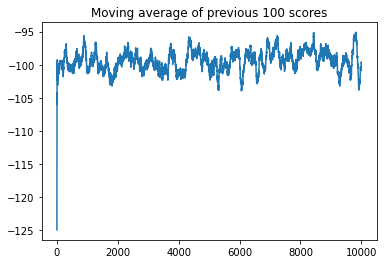

In [10]:
env = gym.make('BipedalWalker-v3')
actionSize = env.action_space.shape[0]

gamesNumber = 10000

plotFile = 'plot_random.png'

bestScore = env.reward_range[0]
historyScores = []

for i in range(gamesNumber):
    env.reset()
    done = False
    score = 0
    while not done:
        action = np.random.uniform(-1.0, 1.0, size=actionSize)
        observation_, reward, done, info = env.step(action)
        score += reward

        if done:
            break

    historyScores.append(score)
    avgScore = np.mean(historyScores[-100:])

    if avgScore > bestScore:
        bestScore = avgScore

    print('episode {} score {:.1f} avg score {:.1f}'.
          format(i, score, avgScore))

x = [i+1 for i in range(gamesNumber)]
plot(x, historyScores, plotFile)

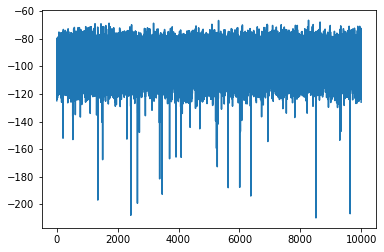

In [11]:
plt.plot(historyScores)
plt.show()

In [12]:
from gym import wrappers

env = gym.make('BipedalWalker-v3')
env = wrappers.Monitor(env, "./gym-results", force=True)
env.reset()

done = False
score = 0
while not done:
    action = np.random.uniform(-1.0, 1.0, size=actionSize)
    observation_, reward, done, info = env.step(action)
    score += reward
    if done:
        env.close()
        break
